In [31]:
# Google Drive マウント
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/My Drive/卒業研究/DeadReckoning_ExperimentalData/ML
%ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/卒業研究/DeadReckoning_ExperimentalData/ML
data/                logs/           model/        Untitled0.ipynb
DeadReckoning.ipynb  makedata.ipynb  others/
graph/               ML_angle.ipynb  __pycache__/
loaddata.ipynb       ML.ipynb        scripts/


In [0]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error

plt.style.use('ggplot')

In [0]:
def load_data(filename):
    data = np.loadtxt(filename, delimiter=',', skiprows=1,
                      unpack=False, dtype=str)
    time = data[:, 0].astype('f8')
    speed = data[:, 1].astype('f8')
    speed = speed[:, np.newaxis]
    xyzwave_list = []
    for row in data:
        xwave = row[2:52].astype('f8')
        ywave = row[52:102].astype('f8')
        zwave = row[102:152].astype('f8')
        xyzwave = xwave**2 + ywave**2 + zwave**2
        xyzwave_list.append(xyzwave)
    xyzwave_list = np.asarray(xyzwave_list)
    return xyzwave_list, speed

In [0]:
# 学習データとテストデータに分割
def splitData(x, t):
    border = int(len(x) * 0.9)
    return (x[:border], t[:border]), (x[border:], t[border:])

In [0]:
# 入力・教師データを対応させたままシャッフル
def shuffleData(x, t):
    zipped = list(zip(x, t))
    np.random.shuffle(zipped)
    x_result, t_result = zip(*zipped)
    return np.asarray(x_result), np.asarray(t_result)

In [0]:
# データの読み込み
x1, t1 = load_data('data/191106_1152/ML.csv')
x2, t2 = load_data('data/191121_1625/ML.csv')
x3, t3 = load_data('data/191204_1956/ML.csv')
x = np.concatenate([x1, x2, x3], axis=0)
t = np.concatenate([t1, t2, t3], axis=0)

x_shuffle, t_shuffle = shuffleData(x, t)
(x_train, t_train), (x_test,  t_test) = splitData(x_shuffle, t_shuffle)

In [0]:
# ハイパーパラメータ
activation = 'relu'
activation_output = 'relu'
learning_rate = 0.001
optimizer = 'adam'
loss = 'mse'

In [38]:
# モデル生成
model = keras.models.Sequential([
    layers.Input(shape=(50,)),
    layers.Dense(100, activation=activation),
    layers.Dropout(0.2),
    layers.Dense( 50, activation=activation),
    layers.Dense( 25, activation=activation),
    layers.Dense( 12, activation=activation),
    layers.Dense(  1, activation=activation_output)
])

adam = keras.optimizers.Adam(lr=learning_rate)
model.compile(optimizer=adam, loss=loss)

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 100)               5100      
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 50)                5050      
_________________________________________________________________
dense_12 (Dense)             (None, 25)                1275      
_________________________________________________________________
dense_13 (Dense)             (None, 12)                312       
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 13        
Total params: 11,750
Trainable params: 11,750
Non-trainable params: 0
__________________________________________________

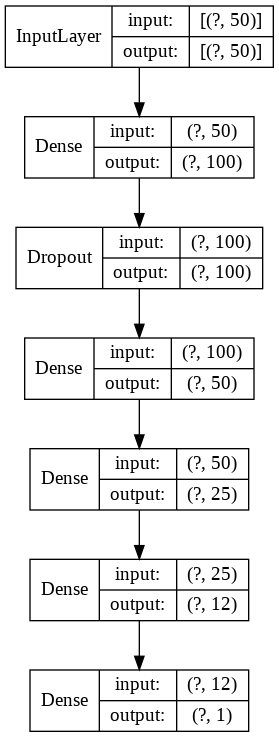

In [39]:
# モデルの可視化
from IPython.display import SVG
from tensorflow.python.keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(model).create(prog='dot', format='svg'))
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='graph/model.png',
           show_shapes=True, show_layer_names=False)

In [40]:
# モデルの訓練
result = model.fit(x_train, t_train, epochs=100)

Train on 2934 samples
Epoch 1/100
2934/2934 [==============================] - 0s 142us/sample - loss: 0.3203
Epoch 2/100
2934/2934 [==============================] - 0s 69us/sample - loss: 0.1134
Epoch 3/100
2934/2934 [==============================] - 0s 75us/sample - loss: 0.0761
Epoch 4/100
2934/2934 [==============================] - 0s 74us/sample - loss: 0.0606
Epoch 5/100
2934/2934 [==============================] - 0s 77us/sample - loss: 0.0541
Epoch 6/100
2934/2934 [==============================] - 0s 73us/sample - loss: 0.0433
Epoch 7/100
2934/2934 [==============================] - 0s 75us/sample - loss: 0.0338
Epoch 8/100
2934/2934 [==============================] - 0s 74us/sample - loss: 0.0300
Epoch 9/100
2934/2934 [==============================] - 0s 72us/sample - loss: 0.0261
Epoch 10/100
2934/2934 [==============================] - 0s 79us/sample - loss: 0.0257
Epoch 11/100
2934/2934 [==============================] - 0s 79us/sample - loss: 0.0233
Epoch 12/100
2934/

In [0]:
# モデルの保存
# model.save('my_model_scalar.h5')

In [0]:
# テスト
y_train = model.predict(x_train)
y_test = model.predict(x_test)

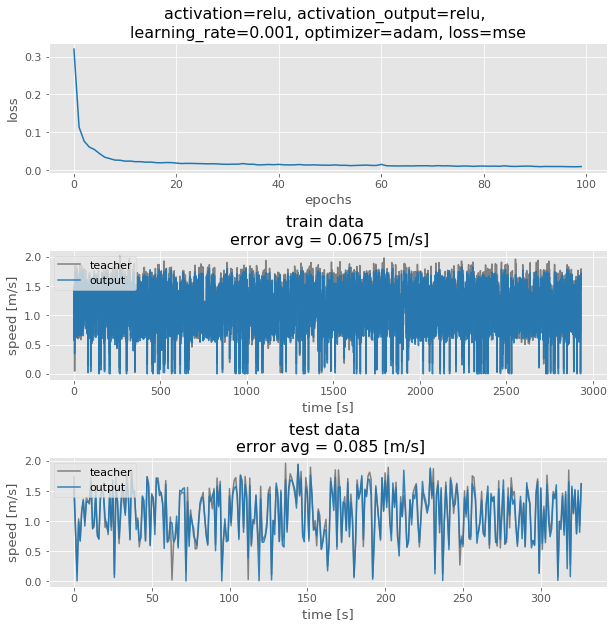

In [43]:
# グラフ表示
plt.rcParams['font.size'] = 11
fig = plt.figure(figsize=(10, 10))

ax1 = fig.add_subplot(311)
ax1.set_title('activation={}, '.format(activation) + 
              'activation_output={}, \n'.format(activation_output) + 
              'learning_rate={}, '.format(learning_rate) +
              'optimizer={}, '.format(optimizer) + 
              'loss={}'.format(loss))
ax1.set_xlabel('epochs')
ax1.set_ylabel('loss')
ax1.plot(result.history['loss'], color='tab:blue', label="training")

ax2 = fig.add_subplot(312)
mae_train = mean_absolute_error(t_train, y_train)
ax2.set_title('train data \n error avg = {0:.3} [m/s]' \
              .format(mae_train))
ax2.set_xlabel('time [s]')
ax2.set_ylabel('speed [m/s]')
ax2.plot(t_train, color='gray', label='teacher')
ax2.plot(y_train, color='tab:blue', label='output', alpha=0.9)
ax2.legend(loc='upper left')

ax3 = fig.add_subplot(313)
mae_test = mean_absolute_error(t_test, y_test)
ax3.set_title('test data \n error avg = {0:.3} [m/s]' \
              .format(mae_test))
ax3.set_xlabel('time [s]')
ax3.set_ylabel('speed [m/s]')
ax3.plot(t_test, color='gray', label='teacher')
ax3.plot(y_test, color='tab:blue', label='output', alpha=0.9)
ax3.legend(loc='upper left')

fig.align_labels()
fig.subplots_adjust(hspace=0.6)
fig.savefig('graph/graph.png')

In [0]:
def test(filename: str):
    x, t = load_data(filename)
    y = model.predict(x)
    return t, y

def plot_test(t, y):
    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(111)
    mae = mean_absolute_error(t, y)
    print(mae)
    # ax.set_title('mean absolute error = {:.3} [m/s]'.format(mae))
    ax.set_xlabel('time [s]')
    ax.set_ylabel('speed [m/s]')
    ax.plot(t, color='gray', label='RTK')
    ax.plot(y, color='tab:blue', label='NN', alpha=0.7)
    ax.legend(loc='upper left')

    # ax2 = fig.add_subplot(212)
    # ax2.set_xlabel('time [s]')
    # ax2.set_ylabel('speed [m/s]')
    # ax2.plot(np.cumsum(t), color='gray', label='RTK')
    # ax2.plot(np.cumsum(y), color='tab:blue', label='NN', alpha=0.7)
    # ax2.legend(loc='upper left')

0.05533505087471591
0.06832671158889753
0.08266442936358742
0.11650178107187792
0.064567833406276


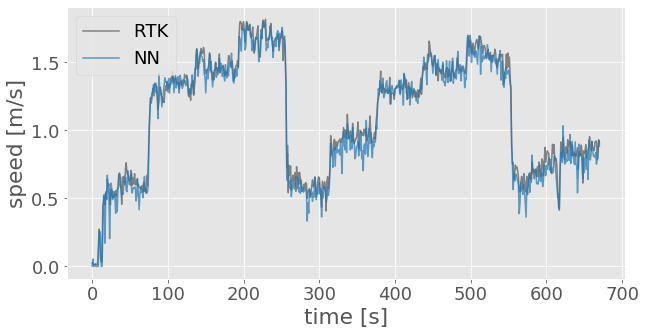

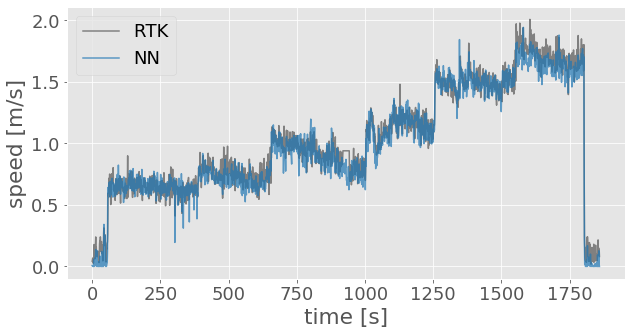

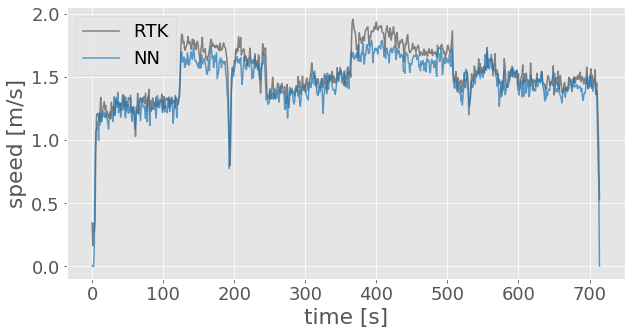

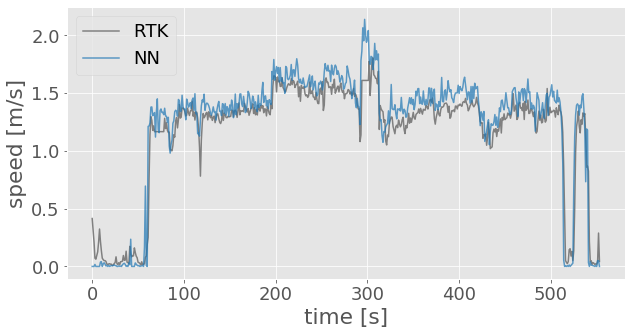

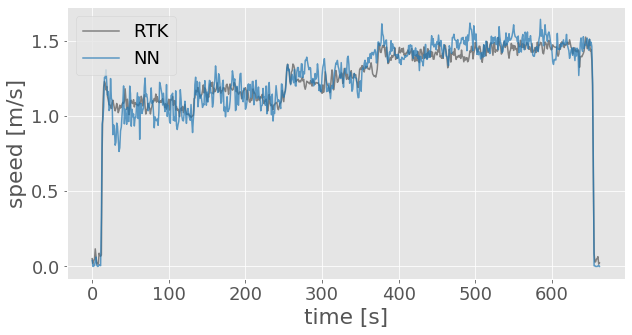

In [45]:
plt.rcParams['font.size'] = 18

t, y = test('data/191106_1152/ML.csv')
plot_test(t[10:-5], y[10:-5])

t, y = test('data/191121_1625/ML.csv')
plot_test(t, y)

t, y = test('data/191204_1956/ML.csv')
plot_test(t, y)

t, y = test('data/191204_2012/ML.csv')
plot_test(t, y)

t, y = test('data/191211_1649/ML.csv')
plot_test(t[15:-5], y[15:-5])